##1.Data Preprocessing

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
pip install tqdm

In [2]:
import json 
import random
import torch
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader

with open('/kaggle/input/instances-val2017-json/instances_val2017.json','r') as file:
    coco_data = json.load(file)


images = coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

<ipython-input-2-c38fc7345889>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import argparse
from torch.utils.tensorboard import SummaryWriter
import shutil
from pprint import pprint
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [63]:
for i in categories:
    print(i)

{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}
{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}
{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}
{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}
{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}
{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}
{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}
{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}
{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
{'supercategory': 'animal', 'id': 16, 'name': 'bird'}
{'supercategory': 'animal', 'id': 17, 'name': 'cat'}
{'supercategory': 'animal', 'id': 18, 'name': 'dog'}
{'supercategory': 'animal', 'id':

In [3]:
num_classes = max([ann['category_id'] for ann in annotations]) + 1

In [4]:
print(num_classes)

91


In [5]:
annotations = [ann for ann in annotations if ann['category_id'] < num_classes]

In [ ]:
print(images[0])

In [ ]:
print(annotations[0])

In [62]:
for i in categories:
    print(i)

{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}
{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}
{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}
{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}
{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}
{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}
{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}
{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}
{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
{'supercategory': 'animal', 'id': 16, 'name': 'bird'}
{'supercategory': 'animal', 'id': 17, 'name': 'cat'}
{'supercategory': 'animal', 'id': 18, 'name': 'dog'}
{'supercategory': 'animal', 'id':

In [6]:
from pycocotools.coco import COCO
annotation_file = '/kaggle/input/instances-val2017-json/instances_val2017.json'
coco = COCO(annotation_file)
images = coco.loadImgs(coco.getImgIds())
new_images = []
for image in images:
    ann_ids = coco.getAnnIds(imgIds=image['id']) 
    annotations = coco.loadAnns(ann_ids)
    image['annotations'] = annotations
    new_images.append(image)
images = new_images
print(images[0]['height'])
print(images[0]['width'])
print(images[0])
    

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
427
640
{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133, 'annotations': [{'segmentation': [[224.24, 297.18, 228.29, 297.18, 234.91, 298.29, 243.0, 297.55, 249.25, 296.45, 252.19, 294.98, 256.61, 292.4, 254.4, 264.08, 251.83, 262.61, 241.53, 260.04, 235.27, 259.67, 230.49, 259.67, 233.44, 255.25, 237.48, 250.47, 237.85, 243.85, 237.11, 240.54, 234.17, 242.01, 228.65, 249.37, 224.24, 255.62, 220.93, 262.61, 218.36, 267.39, 217.62, 268.5, 218.72, 295.71, 225.34, 297.55]], 'area': 1481.3806499999994, 'iscrowd': 0, 'image_id': 397133, 'bbox': [217.62, 240.54, 38.99, 57.75], 'category_id': 44, 'id': 82445}, {'segmentation': [[292.37, 425.1, 340.6, 373.86, 347.63, 256.31, 198.93, 240

##2.Split the data

In [7]:
import random 
from collections import defaultdict
from sklearn.model_selection import train_test_split

def get_image_labels(images):
    labels = []
    for image in images:
        contain_person = any(obj['category_id'] == 1 for obj in image['annotations'])
        labels.append(1 if contain_person else 0)
    return labels 

labels = get_image_labels(images)
train_images,valid_images = train_test_split(images,test_size = 0.1,stratify = labels,random_state = 42)
print(len(train_images))
print(len(valid_images))

4500
500


In [ ]:
print(train_images[2])  # Kiểm tra thông tin ảnh đầu tiên
# Kiểm tra 5 annotation đầu tiên


##3.Build the Dataset

In [23]:
import torch
import os
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class myDataset(Dataset):
    def __init__(self, images, root_dir, transform=None):
        self.images = images
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_WIDTH, img_HEIGHT = img_info['width'], img_info['height']
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        img = Image.open(img_path).convert('RGB')

        new_WIDTH, new_HEIGHT = 256, 256
        scale_x = new_WIDTH / img_WIDTH
        scale_y = new_HEIGHT / img_HEIGHT

        boxes = []
        labels = []

        for ann in img_info.get('annotations', []):
            if 'bbox' not in ann:
                continue

            xmin, ymin, width, height = ann['bbox']
            xmax = xmin + width
            ymax = ymin + height

            xmin *= scale_x
            xmax *= scale_x
            ymin *= scale_y
            ymax *= scale_y

            if xmin >= xmax or ymin >= ymax:
                continue
            if width <= 0 or height <= 0:
                continue

            xmin = max(0, min(xmin, new_WIDTH - 1))
            xmax = max(0, min(xmax, new_WIDTH - 1))
            ymin = max(0, min(ymin, new_HEIGHT - 1))
            ymax = max(0, min(ymax, new_HEIGHT - 1))

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            img = self.transform(img)

        return img, target

In [24]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()
])

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [28]:
train_dataset = myDataset(train_images,'/kaggle/input/images/val2017',transform=transform)
valid_dataset = myDataset(valid_images,'/kaggle/input/images/val2017',transform = transform)
train_loader = DataLoader(train_dataset,batch_size = 16,shuffle = True,drop_last = True,collate_fn = collate_fn,num_workers = 4,pin_memory = True)
valid_loader = DataLoader(valid_dataset, batch_size = 16,shuffle = False,collate_fn = collate_fn,num_workers = 4,drop_last = False, pin_memory = True)

In [29]:
print(train_dataset[100])

(tensor([[[0.3059, 0.3098, 0.3020,  ..., 0.0745, 0.0706, 0.0745],
         [0.3059, 0.3059, 0.3020,  ..., 0.0706, 0.0745, 0.0706],
         [0.3059, 0.3059, 0.3059,  ..., 0.0745, 0.0784, 0.0745],
         ...,
         [0.0784, 0.0784, 0.0824,  ..., 0.8196, 0.8235, 0.8196],
         [0.0745, 0.0745, 0.0706,  ..., 0.8431, 0.8431, 0.8431],
         [0.0784, 0.0824, 0.0745,  ..., 0.8353, 0.8353, 0.8392]],

        [[0.2902, 0.2941, 0.2863,  ..., 0.2667, 0.2627, 0.2667],
         [0.2902, 0.2902, 0.2863,  ..., 0.2627, 0.2667, 0.2627],
         [0.2902, 0.2902, 0.2902,  ..., 0.2667, 0.2706, 0.2667],
         ...,
         [0.1333, 0.1333, 0.1373,  ..., 0.8196, 0.8196, 0.8157],
         [0.1294, 0.1333, 0.1412,  ..., 0.8392, 0.8431, 0.8431],
         [0.1373, 0.1451, 0.1490,  ..., 0.8314, 0.8275, 0.8275]],

        [[0.2471, 0.2510, 0.2471,  ..., 0.5647, 0.5608, 0.5647],
         [0.2510, 0.2510, 0.2471,  ..., 0.5608, 0.5647, 0.5608],
         [0.2549, 0.2549, 0.2549,  ..., 0.5686, 0.5686, 0

In [31]:
print(valid_dataset[0])

(tensor([[[0.8235, 0.8235, 0.8431,  ..., 0.6510, 0.6353, 0.6314],
         [0.7804, 0.7922, 0.8000,  ..., 0.6235, 0.6157, 0.6078],
         [0.7490, 0.7490, 0.7569,  ..., 0.4118, 0.4118, 0.3882],
         ...,
         [0.2000, 0.1961, 0.1882,  ..., 0.0824, 0.0588, 0.0588],
         [0.2078, 0.1804, 0.1569,  ..., 0.0588, 0.0745, 0.0275],
         [0.1922, 0.1843, 0.1412,  ..., 0.0745, 0.0314, 0.0118]],

        [[0.8392, 0.8588, 0.8824,  ..., 0.6392, 0.6392, 0.6314],
         [0.8000, 0.8078, 0.8157,  ..., 0.6314, 0.6275, 0.6196],
         [0.7608, 0.7608, 0.7686,  ..., 0.4235, 0.4235, 0.4157],
         ...,
         [0.1608, 0.1765, 0.1686,  ..., 0.0824, 0.0588, 0.0588],
         [0.1569, 0.1686, 0.1412,  ..., 0.0588, 0.0745, 0.0275],
         [0.1333, 0.1451, 0.1216,  ..., 0.0784, 0.0353, 0.0118]],

        [[0.8157, 0.8431, 0.8824,  ..., 0.5922, 0.5882, 0.5804],
         [0.7725, 0.7765, 0.7882,  ..., 0.5922, 0.5882, 0.5804],
         [0.7255, 0.7255, 0.7333,  ..., 0.3843, 0.3804, 0

In [ ]:
img,target = train_dataset[100]
print(f"Image shape: {img.shape}")
print(f"Boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")
print(type(target))

In [ ]:
def get_args():
    parser = argparse.ArgumentParser(description="Object Detection")
    parser.add_argument("--data_path", type=str, default="/kaggle/input/images/val2017", help="the root folder of the data")
    parser.add_argument("--epochs", default=50, type=int, help="Total number of epochs")
    parser.add_argument("--batch_size", default=4, type=int)
    parser.add_argument("--image_size", default=416, type=int)
    parser.add_argument("--lr", default=0.001, type=float, help="initial learning rate")
    parser.add_argument("--momentum", default=0.9, type=float, help="momentum")
    parser.add_argument("--weight_decay", default=5e-4, type=float, help="weight decay")
    parser.add_argument("--es_min_delta", type=float, default=0.0,
                        help="Early stopping's parameter: minimum change loss to qualify as an improvement")
    parser.add_argument("--es_patience", type=int, default=0,
                        help="Early stopping's parameter: number of epochs with no improvement after which training will be stopped. Set to 0 to disable this technique.")
    # parser.add_argument("--checkpoint", type=str, default="trained_models/last.pt", help="path to model checkpoint file")
    parser.add_argument("--checkpoint", type=str, default=None, help="path to model checkpoint file")
    parser.add_argument("--log_path", type=str, default="tensorboard/pascal_voc")
    parser.add_argument("--save_path", type=str, default="trained_models")

    args = parser.parse_args()
    return args

##4.Build the Model

In [12]:
import torch.nn as nn
import torch
import torchvision 
from torch.optim import Adam
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet50
from torchvision.models.detection import(
    FasterRCNN_ResNet50_FPN_Weights,
    FasterRCNN_ResNet50_FPN_V2_Weights,
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
optimizer = Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 177MB/s]  


In [32]:
print(device)

cuda


In [33]:
model = model.to(device)

In [15]:
torch.cuda.is_available()

True

In [ ]:
#Release the memory before training
!nvidia-smi


In [ ]:
import torch
torch.cuda.empty_cache()


In [16]:
import numpy as np 

4. Train Model

In [35]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = []
    train_progress_bar = tqdm(train_loader, colour='cyan')
    for iter, (images, targets) in enumerate(train_progress_bar):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():
            output = model(images, targets)
            losses = sum([loss for loss in output.values()])

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss.append(losses.item())
        avg_loss = np.mean(train_loss)
        train_progress_bar.set_description('Epoch {}/{}. Loss {:0.4f}'.format(epoch + 1, num_epochs, avg_loss))

<ipython-input-35-212d6079d41a>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/281 [00:00<?, ?it/s]

<ipython-input-35-212d6079d41a>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

5.Evaluate Model

In [36]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch

def evaluate(model, valid_loader, device):
    model.eval()
    metric = MeanAveragePrecision()
    val_progress_bar = tqdm(valid_loader, colour='green')

    with torch.no_grad():
        for images, targets in val_progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

            predictions = model(images)

            # Chuẩn bị dữ liệu để tính mAP
            preds = []
            gts = []
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu()
                pred_scores = pred['scores'].cpu()
                pred_labels = pred['labels'].cpu()
                gt_boxes = target['boxes'].cpu()
                gt_labels = target['labels'].cpu()

                preds.append({
                    "boxes": pred_boxes,
                    "scores": pred_scores,
                    "labels": pred_labels
                })
                gts.append({
                    "boxes": gt_boxes,
                    "labels": gt_labels
                })

            # Cập nhật metric
            metric.update(preds, gts)
    result = metric.compute()
    return result

In [39]:
valid_result = evaluate(model,valid_loader,device)
print(f'Validation mAP: {valid_result["map"].item():.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Validation mAP: 0.0455


6.Test Model

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import builtins
def test(model, valid_loader, device, num_images=1, confidence_threshold=0.5):
    model.eval()
    
    category_mapping = {
        1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
        6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
        11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
        16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep',
        21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe',
        27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase',
        34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite',
        39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard',
        43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork',
        49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple',
        54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog',
        59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch',
        64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet',
        72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard',
        77: 'cell phone', 78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink',
        82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors',
        88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'
    }

    data_iter = builtins.iter(valid_loader)
    images, targets = next(data_iter)

    with torch.no_grad():
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        predictions = model(images)

        for i in range(min(num_images, len(images))):
            image = images[i].cpu().permute(1, 2, 0).numpy()  
            image = (image * 255).astype(np.uint8)  

            pred_boxes = predictions[i]['boxes'].cpu().numpy()
            pred_labels = predictions[i]['labels'].cpu().numpy()
            pred_scores = predictions[i]['scores'].cpu().numpy()

            high_confidence_indices = pred_scores > confidence_threshold
            pred_boxes = pred_boxes[high_confidence_indices]
            pred_labels = pred_labels[high_confidence_indices]
            pred_scores = pred_scores[high_confidence_indices]

            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            ax = plt.gca()

            for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                xmin, ymin, xmax, ymax = box
                width = xmax - xmin
                height = ymax - ymin
                rect = plt.Rectangle((xmin, ymin), width, height, fill=False, color='red', linewidth=2)
                ax.add_patch(rect)
                category_name = category_mapping.get(label, "unknown")
                plt.text(xmin, ymin - 5, f"{category_name}: {score:.2f}", color='red', fontsize=12, backgroundcolor='white')

            plt.axis('off')
            plt.show()

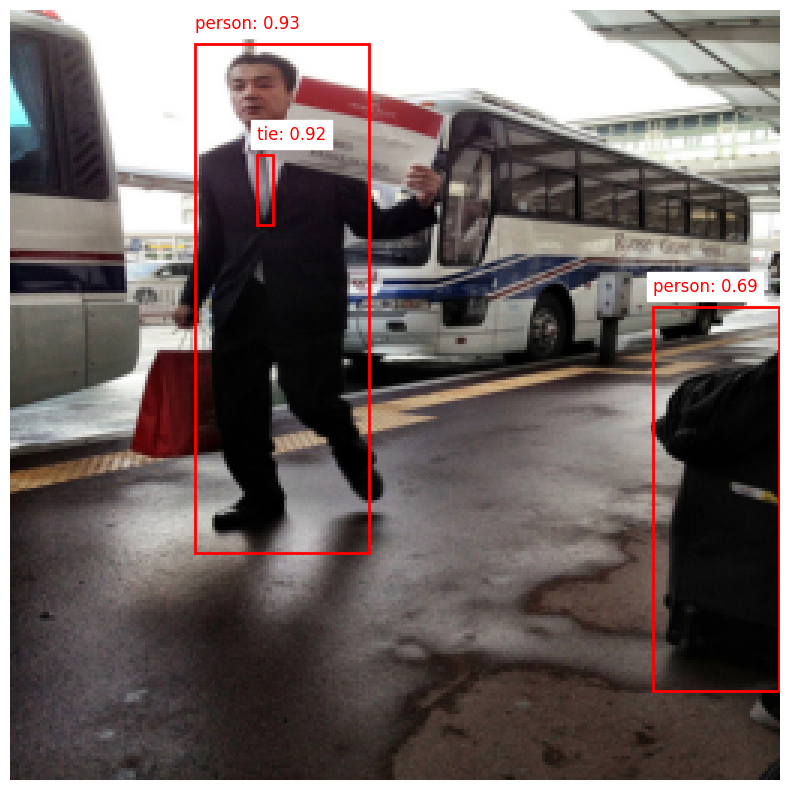

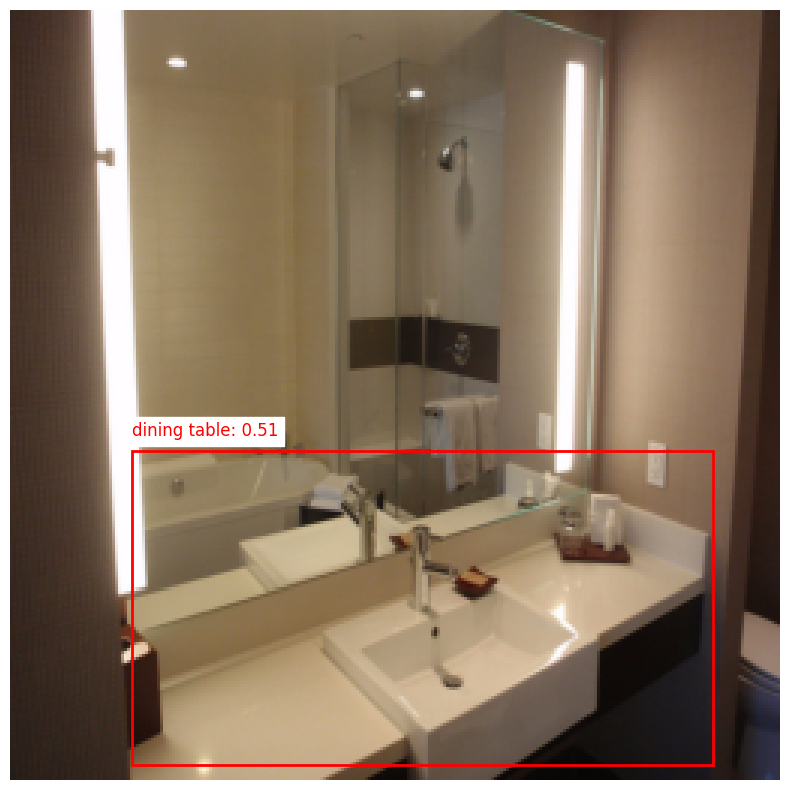

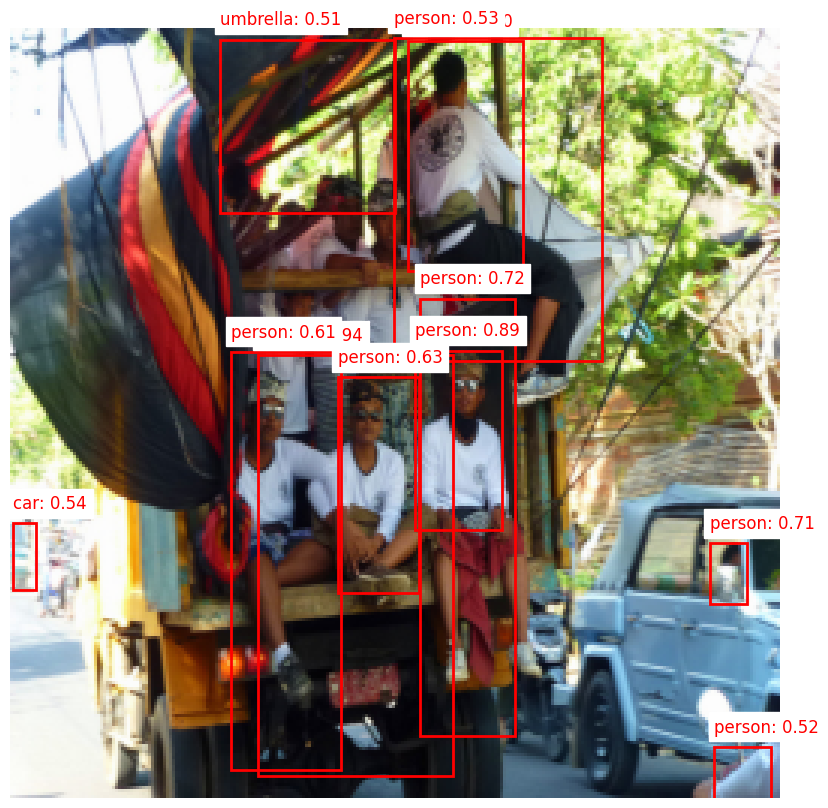

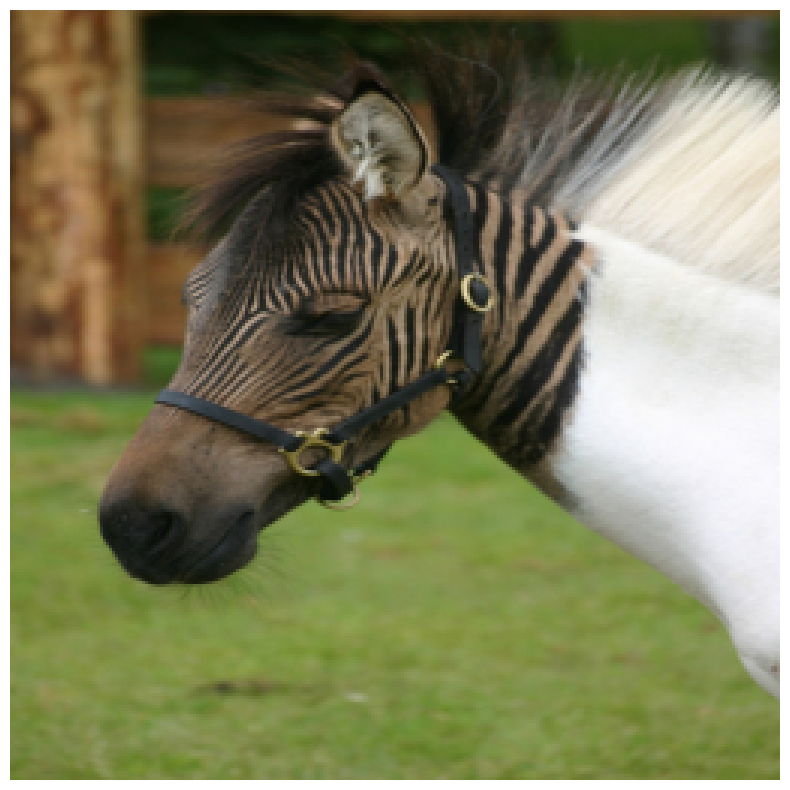

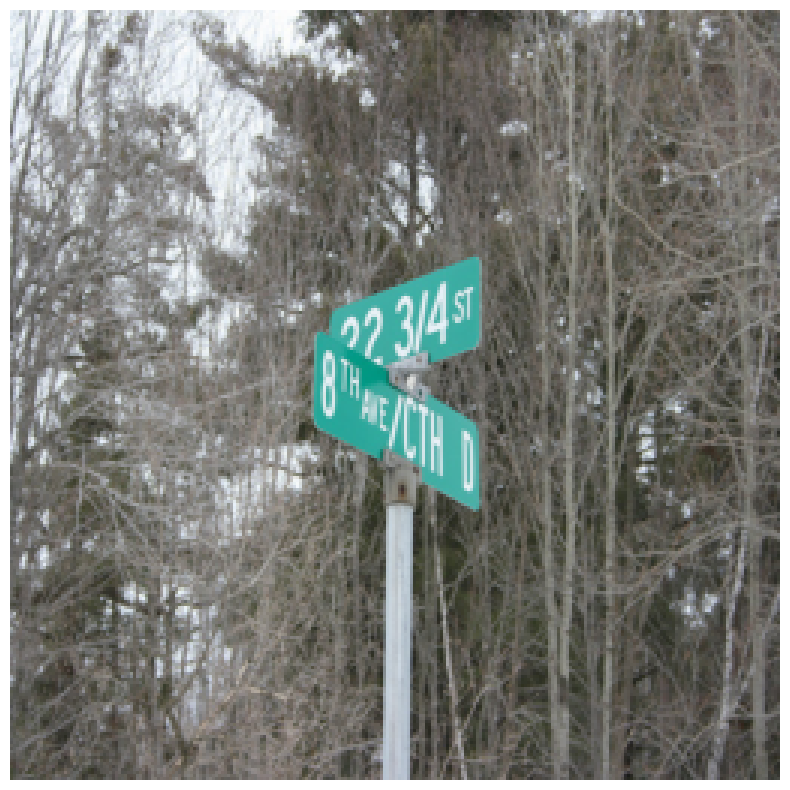

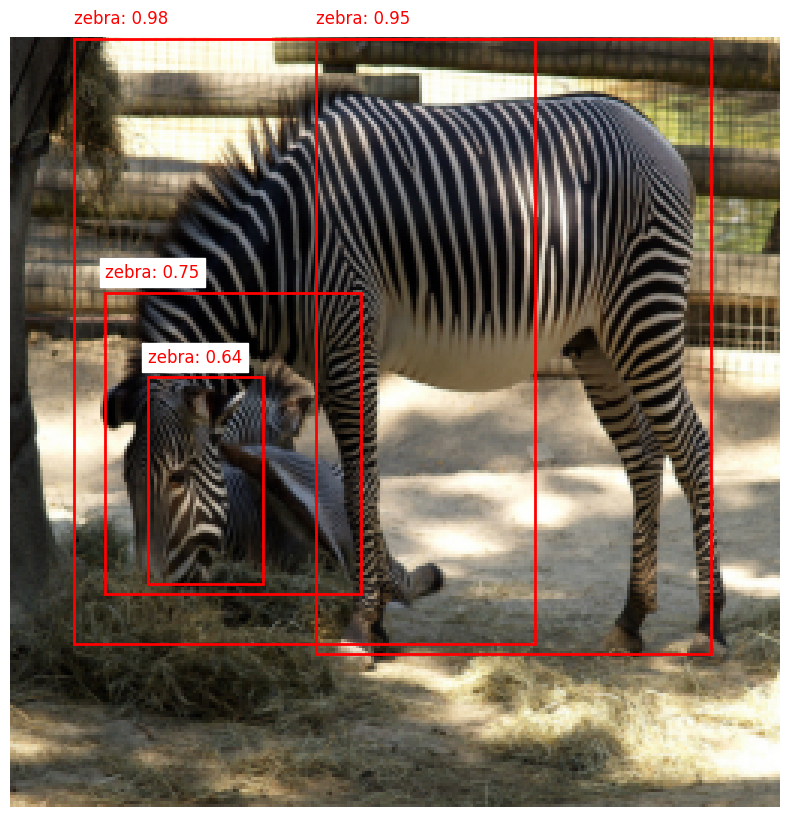

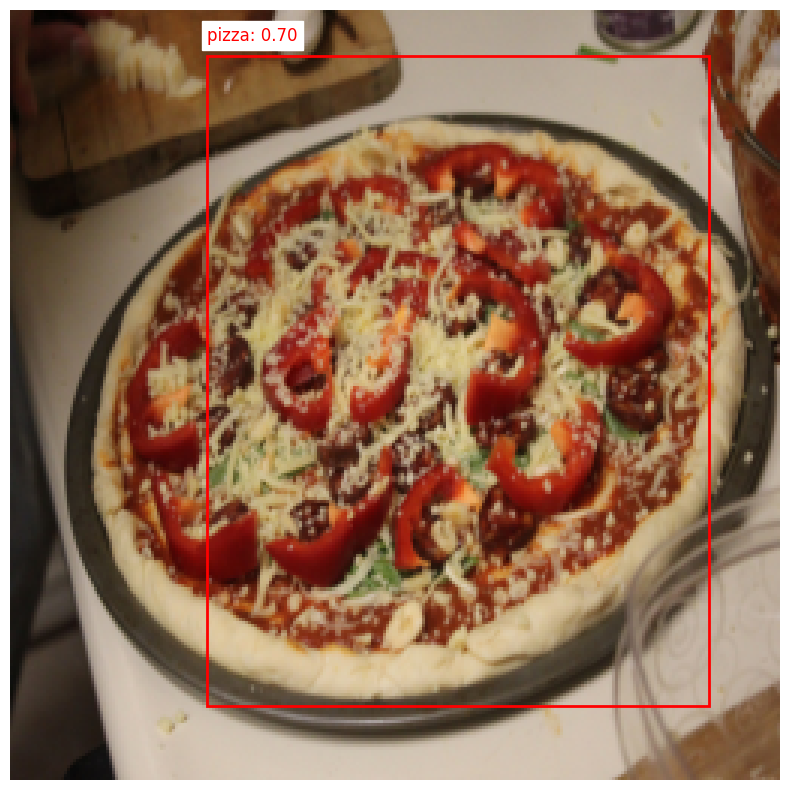

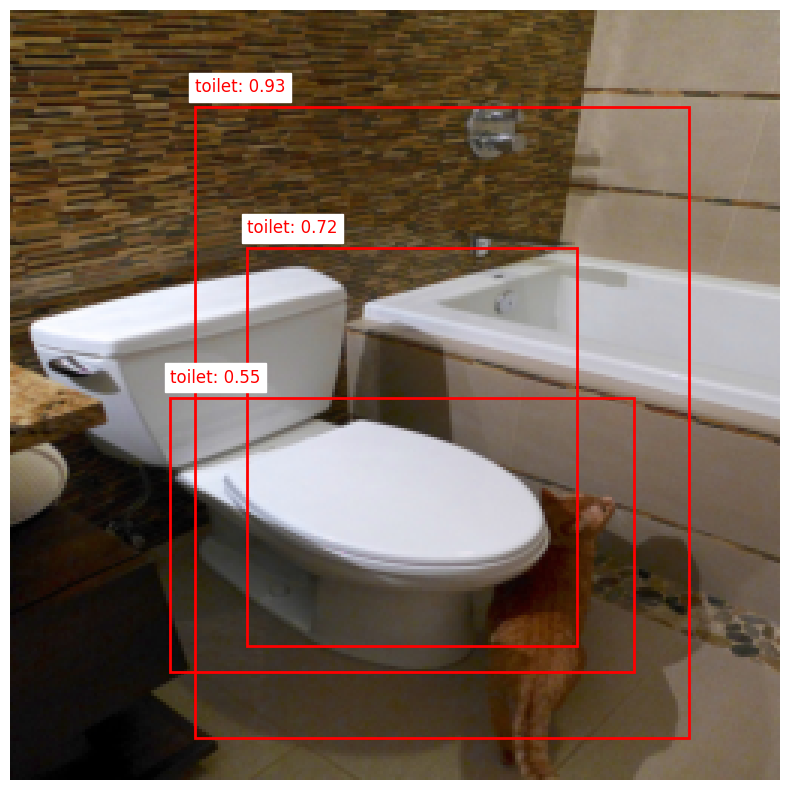

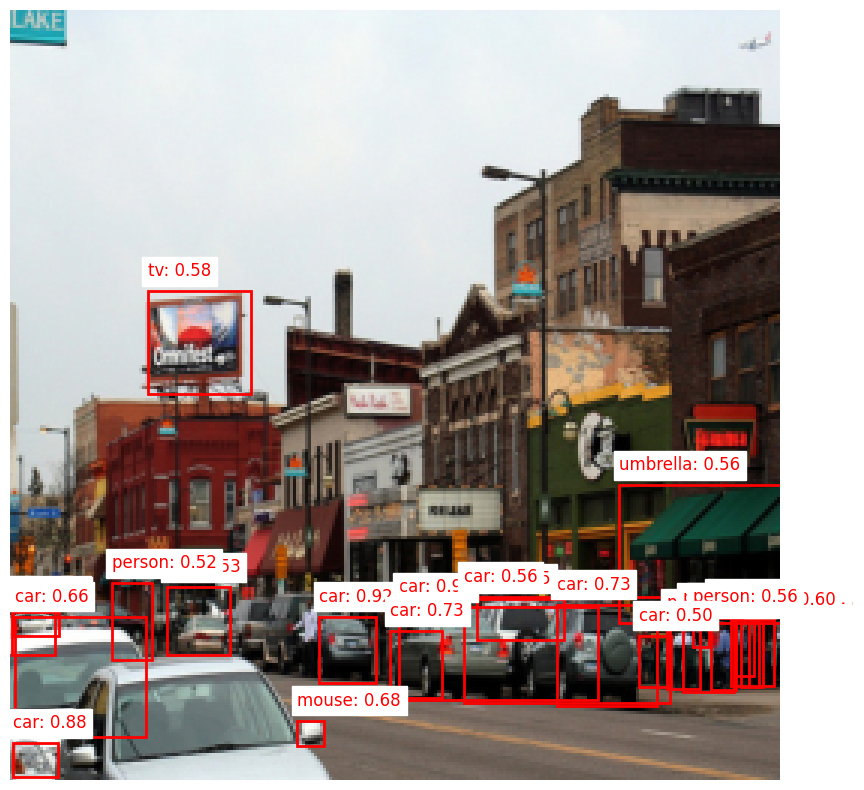

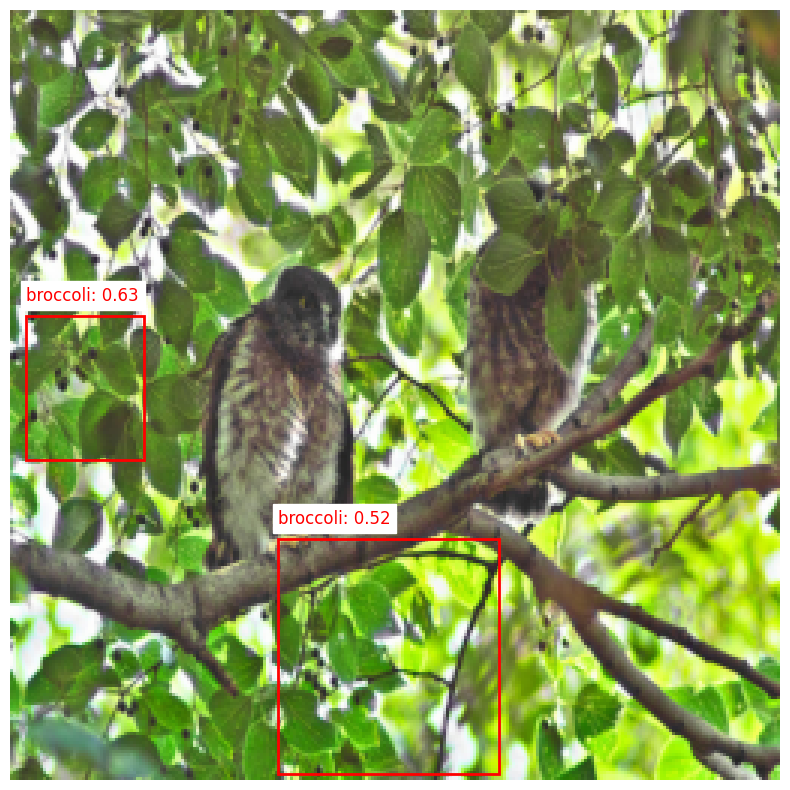

In [69]:
 test(model, valid_loader, device, num_images = 10)